# Tutorial: 딥러닝으로 캐릭터 이름 짓기

이번 포스팅에서 소개할 딥러닝 알고리즘은 Recurrent Neural Network (RNN)이다. Recurrent의 사전적 정의는 "반복적인"(repeatedly)이다. RNN은 반복적인 연결을 통해 연속적인(sequential)한 데이터를 처리하는 인공신경망의 한 종류다.

분류모델을 만들 때 사용했던 손글씨 이미지나 고양이 사진은 그 자체로는 sequential한 데이터가 아니다. 시간에 따른 주식의 가격 변화나 소설에 쓰인 텍스트는 연속적인 특징을 가진다. 과거의 호가와 거래량이 지금의 가격에 영향을 미친다. 소설 속 주인공이 전쟁에 참전하는 것으로 단락이 마무리되었다면, 다음 단락은 전쟁에 대한 어떤 언급이 들어갈 확률이 높아진다.

RNN은 연속적인 데이터가 가진 그 사이의 관계를 학습하는데 사용할 수 있는 유용한 도구다. 과거 주식 시장의 흐름을 학습하면 미래의 가격 변동을 예측할 수 있다. 리뷰 데이터에 대한 감성 분석 모델을 만들어 자사 제품에 대한 긍부정 동향 분석에 사용할 수도 있다. 뿐만 아니라 우리의 언어가 가진 연속적인 규칙을 학습해 그럴듯한 무언가를 만들어내는데도 RNN을 써볼 수 있다.

이번 포스팅에서는 이름을 짓는 CharRNN 모델을 만들어보면서 RNN을 맛보도록 하자.

## 0. NameGenerator

여기서 만들어볼 NameGenerator는 **문화권**, **성별**, 그리고 **시작 글자**를 입력받아, 그 조건에 해당되는 그럴듯한 이름 3가지 정도를 리턴하는 생성모델이다. 

예를 들어 "C"로 시작하는 스페인 남자 이름을 지어보자.

### case 1. "Spanish", "boy", "C"
> Carlo, Calvan, Calvito

뭔가 스페인 느낌이 나는 남성적인 이름이 반환되었다.   

이번에는 "Mi"로 시작하는 여성 이름을 국적만 바꿔서 만들어보자.

### case 2. "British", "girl", "Mi"
>Milli, Milda, Millie

### case 3. "Japanese", "girl", "Mi"
>Mika, Miko, Michi

### case 4. "Spanish", "girl", "Mi"
>Miladia, Miladena, Miradella

국적에 따른 느낌이 묻어나온다.


이번에는 성별에 따른 차이를 살펴보자.

### case 5. "Swedish", "girl", "Mi"
>Mila, Milla, Millisa

### case 6. "Swedish", "boy", "Mi"
>Milad, Milek, Milis

성별에 따른 특성이 이름의 끝에서 묻어나온다.

이를 사용하면 무엇을 할 수 있을까? 자신의 아바타라 할 수 있는 게임 캐릭터의 이름을 짓거나, 혹은 좀 더 특색있는 자신의 영문 이름을 짓는데 써볼 수 있지 않을까? 이름 짓는 귀찮음 대신에 "내 이름은 딥러닝으로 지었다"라는 흥미로운 사이드 스토리가 생길수도 있겠다.

## 1. Approach

앞에서 소개한 NameGenerator는 **문화권**, **성별** 그리고 **이름**을 데이터로 사용한다. 그리고 이름을 구성하는 각 글자의 흐름을 RNN이 학습한다. 좀 더 엄밀히 표현하면, $t$번째 글자를 입력으로 받아 $t+1$번째 글자가 무엇이 될지 예측하는 문제를 푸는 것이다. 

손글씨나 고양이 얼굴 인식에서는 각 이미지(input)별로 정답(target)이 필요했으나, 여기에서는 별도의 정답이 필요없다. 왜냐하면 이름 데이터 그 자체로 input과 target이 존재한다. 예를 들어 "Mila"라는 이름에서 우리는 "M" 다음 글자가 "i"여야 한다는 것을 데이터 자체에서 알고 있다.

우리가 만들려는 글자단위(character-level) 모델이 적절하게 학습된다면, 이 모델은 문화권, 성별 설정과 시작 글자를 입력받아 첫번째 글자를 예측한다. 그리고 이 글자를 다시 반복해서 모델에 집어넣으면 두번째 글자가 출력된다. 이 과정을 "eos"(이름의 끝을 알리는 구분자)가 출력될때가지 계속하면 딥러닝에 의한 이름이 만들어진다. 간혹 학습 데이터셋에 있는 결과가 나올때도 있지만 전혀 새로운 이름이 만들어질 때도 있다.

여기서 간단히 소개한 이 과정을 다음과 같은 순서로 쪼개어 더 자세히 살펴보자.
- Dataset
- Text Data Preprocessing
- Network Design
- Training
- Generation with Beam-Search

## 2. Dataset

모델 학습을 위해 인터넷에서 인기있는 아기 이름을 수집해 데이터로 만들어두었다.  
이 데이터는 영문이름, 성별, 문화권 정보를 포함하고 있다.
`pandas` 라이브러리를 사용해 간단히 읽어들여보자.

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("data/full_version/train/train_dataset.csv")
val_df = pd.read_csv("data/full_version/val/val_dataset.csv")

In [3]:
train_df.head()

,babyname,sex,origin
0,Athenasia,girl,Greek
1,Jace,boy,Hebrew
2,Sheryll,girl,Greek
3,Bardulf,boy,British
4,Alfeo,boy,British


데이터셋의 크기와 성별 / 문화권에 따른 이름 수를 간단히 체크해본다.

In [4]:
len(train_df), len(val_df)

(33609, 3735)

In [5]:
train_df.groupby('sex').babyname.count()

sex
boy     13991
girl    19618
Name: babyname, dtype: int64

In [6]:
train_df.groupby('origin').babyname.count()

origin
African              95
American            666
Arabic              802
Aramaic             131
Armenian              2
Australian            3
Babylonian           13
Basque                8
British            4205
Cambodian             2
Celtic              113
Chinese              19
Czech                34
Danish               66
Dutch                16
Egyptian             13
French             1311
Gaelic              269
German             2354
Ghanaian             39
Greek              3314
Hawaiian            123
Hebrew             3188
Hungarian            65
Indian              262
Irish              1133
Italian             371
Japanese            125
Latin              3969
Modern               75
Native American     120
Nigerian             12
Norse               284
Norwegian            18
Persian             133
Polish               48
Portuguese           12
Russian             187
Sanskrit            150
Scandinavian        344
Scottish            365
Slavic   

인터넷에서 크롤링한 데이터다 보니 문화권에 따른 불균형이 심함을 알 수 있다.

## 1. Text Data Preprocessing
<a href="https://torchtext.readthedocs.io/en/latest/">`torchtext`</a>는 자연어처리(Natural Language Processing)을 할 때 사용할 수 있는 유용한 python 라이브러리다. torchtext를 사용하면 글자나 단어를 모델이 이해할 수 있는 숫자 형태로 쉽게 바꾸고 다시 되돌릴 수 있다.

In [7]:
from torchtext import data
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu" # gpu 사용불가시 cpu로 학습 설정

### 글자 -> 숫자로. 어떻게?

"British", "girl", "M"은 우리가 이해할 수 있는 글자다. 수치연산을 하는 딥러닝 모델은 글자를 바로 처리하지 못한다. 따라서 적절한 숫자로 이 글자를 표현해야 한다.

가장 쉽게 생각할 수 있는 것은 숫자를 하나씩 할당하는 방식이다. "American"에 1을, "British"에 2를 주는 방식으로 모든 51개 문화권에 숫자를 하나씩 부여한다. 그런데 "British"가 2라고 해서 American보다 2배 크다는 의미는 아니다. 이 숫자는 GDP나 국토의 너비 따위를 의미하는 것이 아니라 순번 인덱스일 뿐이다.

숫자가 가진 인덱스의 의미를 표현하기 위해 이 숫자를 해당 숫자의 위치가 1인 벡터로 표현한다. 잠시 문화권의 갯수가 3개라고 생각해보자. "American", "British", "Korean". 그리고 앞에서부터 0, 1, 2 숫자를 부여하면 벡터로 표현된 각 문화권은 다음과 같다.
> "American" = [1, 0, 0]  
> "British" = [0, 1, 0]  
> "Korean" = [0, 0, 1]  

이렇게 변환하는 방식을 One-Hot Encoding이라 한다.

성별도 "boy"면 [0, 1]을, "girl"이면 [1, 0]으로 표현할 수 있다.

이름 역시 One-Hot Encoding의 방식을 사용한다. 하지만 그 전에 몇가지 스텝을 거쳐야 한다.
1. 대문자 -> 소문자
2. string -> [chr, chr, crh]
3. "bos", "eos" 추가
    
대문자를 소문자로 치환하면 모델이 출력해야할 경우의 수가 약 1/2정도로 줄어들기 때문에 학습 난이도가 조금 내려간다(대문자가 가진 정보가 크게 의미없다고 판단하는 경우). 우리는 이름 자체가 아닌 글자와 글자 사이의 관계를 학습하는 것이므로, 결합되어있는 string을 잘라다가 글자의 리스트로 만든다. 1번과 2번 과정을 아래 `tokenizer`라는 함수를 통해 구현하였다.

마지막 3번은 torchtext.data에서 제공하는 `field`를 통해 쉽게 처리할 수 있어 굳이 구현하지 않아도 된다.

문화권과 성별은 sequential 데이터는 아니지만 이 역시 `field`를 통해 처리할 수 있다. 아래와 같이 `onehot`함수를 통해 해당 리스트와 사전(vocab)을 인자로 넘기면 `torch`의 tensor로 변환하는 함수를 만들고, 이를 `field`에 넘기면 된다.

### Tokenizer
tokenizer는 이름을 소문자로 바꾼 후 글자 단위로 자른다.   
"Lucy" => ["l", "u", "c", "y"]

In [8]:
def tokenizer(text):
    return list(text.lower())

In [9]:
tokenizer("Lucy")

['l', 'u', 'c', 'y']

### One Hot Encoder
onehot은 사전 정보를 사용해 리스트를 onehot tensor로 변환한다.

In [10]:
def onehot(alist, vocab):
    """
    TorchText의 Field에 사용할 one-hot Encoder 함수
    """
    # alist = [2, 1, 1]
    # _tensor = [[1, 0, 0]]
    _tensor = torch.tensor(alist).data.sub_(1).unsqueeze(1)

    # _onehot = [[0, 0], [0, 0], [0, 0]]
    _onehot = torch.zeros((len(alist), len(vocab) - 1), dtype=torch.float)

    # _onehot = [[0, 1], [1, 0], [1, 0]]
    _onehot.scatter_(1, _tensor, 1)
    return _onehot

### DataLoader
아래 DataLoader는 딥러닝 학습에 사용할 데이터를 모델에 계속 부어주는 파이프라인이다.

보통 딥러닝을 학습할 때 데이터를 대량으로 준비하는데, 이 데이터를 한번에 모델에 다 붓지 않는다. 데이터를 여러 작은 배치(mini-batch)로 쪼개서 하나씩 집어넣으면서 학습한다. 여기서 그 작은 배치의 크기를 결정하는 것이 DataLoader의 인자인 batch_size다. 

batch_size는 모델러의 주관에 따라 달라질 수 있는 hyper-parameter로, 1부터 데이터셋의 크기 사이의 숫자를 지정할 수 있다. 여기서는 16으로 설정했다.

DataLoader는 **이름**, **성별**, **문화권** 3가지 `Field`를 가진다. 각 필드는 데이터의 성격에 따라 정의한다. 이름은 sequential한 데이터이며, 앞서 정의한 함수 tokenizer를 사용하고, 이름의 첫과 끝 구분자를 사용한다. 

문화권과 성별 데이터는 sequential한 데이터는 아니고, onehot 함수를 postprocessing으로 사용하며, 이를 위해 사전을 가진다. 

이렇게 설정한 세가지 field는 데이터셋(`data.TabularDataset`)을 구축하는데 사용한다. TabularDataset은 지정한 저장 경로로부터 csv파일을 불러온 후, fields에서 지정한 컬럼 명과 field를 맵핑하여 데이터 파이프라인을 연결한다. 즉, 위에서 `pandas`로 살펴본 데이터프레임이 그대로 처리되어 데이터셋으로 만들어진다고 볼 수 있다.

마지막으로 이 데이터셋을 딥러닝 모델에 넣기 좋게 mini-batch를 생산하는 generator로 만든 것이 `train_iter`와 `val_iter`다. 이 두가지를 사용해서 학습을 수행하게 된다. 

In [11]:
class DataLoader(object):

    def __init__(self, data_dir, batch_size):
        """
        :param: data_dir: 데이터가 위치한 폴더 경로
        :param: batch_size: 미니배치 사이즈의 크기
        """
        
        """
        BABYNAME - 이름 텍스트이므로 sequential 데이터임
                   tokenizer로 이름을 글자 리스트로 바꾼 후
                   "<bos>"와 "<eos>"로 시작과 끝을 지정해준다(옵션).
                   tensor의 맨 앞이 batch 차원이 되도록(batch_first=True) 설정한다.
        """
        self.BABYNAME = data.Field(sequential=True, tokenize=tokenizer,
                                   batch_first=True, init_token="<bos>", eos_token="<eos>")
        
        """
        SEX, Origin - 성별과 국적이므로 이들은 sequential 데이터가 아니다.
                      use_vocab=True를 통해 나올 수 있는 가짓수를 데이터에서 계산한다.
                      마지막으로 onehot encoding을 통해 tensor로 변환한다.
        """
        self.SEX = data.Field(sequential=False, use_vocab=True, postprocessing=onehot)
        self.ORIGIN = data.Field(sequential=False, use_vocab=True, postprocessing=onehot)

        
        """
        데이터 저장 경로로부터 csv파일을 읽어들인 후, 각 column과 앞서 지정한 Field를 맵핑하여
        dataset으로 만든다.
        """
        self.train_ds, self.val_ds = data.TabularDataset.splits(
            path=data_dir, skip_header=True, train='train/train_dataset.csv',
            validation='val/val_dataset.csv', format='csv',
            fields=[('babyname', self.BABYNAME), ('sex', self.SEX), ('origin', self.ORIGIN)]
        )
        

        """
        글자들의 전체 가짓수, 성별 가짓수, 국적의 사전을 만들어 숫자를 할당한다.
        """
        self.build_vocab()

        """
        batch_size로 mini-batch로 데이터를 쪼개서 넘기는 generator를 만든다.
        """
        self.train_iter, self.val_iter = data.BucketIterator.splits(
            (self.train_ds, self.val_ds), batch_sizes=(batch_size, batch_size), device=device,
            repeat=False, sort_key=lambda x: len(x.babyname))


    def build_vocab(self):
        self.BABYNAME.build_vocab(self.train_ds, self.val_ds)
        self.SEX.build_vocab(self.train_ds, self.val_ds)
        self.ORIGIN.build_vocab(self.train_ds, self.val_ds)
        print("vocab built")

DataLoader 인스턴스를 생성하면 그 내부의 build_vocab 함수가 동작한다. 이 함수는 글자, 성별, 문화권이 가질 수 있는 모든 경우의 수를 계산하여, 각 경우에 대해 인덱스를 부여한다. 데이터 로더를 만든 후, mini-batch가 어떤 형태의 데이터를 전달하는지 살펴보자.

In [12]:
data_dir = 'data/full_version'
batch_size = 16
data_loader = DataLoader(data_dir, batch_size)

vocab built


In [13]:
# 테스트해보자.
sample = next(iter(data_loader.train_iter))
sex = sample.sex.float()
origin = sample.origin.float()

먼저 성별과 문화권을 살펴보자.

In [14]:
sex

tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.]])

In [15]:
sex.size()

torch.Size([16, 2])

성별 텐서의 크기는 16x2다. 여기서 16은 앞서 지정한 batch_size다. 즉, 16개의 이름에 해당되는 성별이 출력되었다. 2는 남자, 여자로 성별의 경우의 수다. 

In [16]:
origin.size()

torch.Size([16, 51])

문화권 역시 첫번째 차원이 batch 차원인 16이다. 51은 모든 문화권의 가짓수를 의미한다.

다음으로 이름이다.

In [17]:
sample.babyname

tensor([[  2,  11,  13,   4,   8,   5,   5,   6,   4,   3,   1,   1],
        [  2,  17,   5,   8,   5,  11,  12,   4,   3,   1,   1,   1],
        [  2,  12,   4,  20,   5,   9,   3,   1,   1,   1,   1,   1],
        [  2,  20,   9,   4,   6,   7,  11,   8,   4,  23,   3,   1],
        [  2,  18,  24,  12,  10,   6,   3,   1,   1,   1,   1,   1],
        [  2,  19,   9,   7,  11,  12,  10,  24,  13,  10,   9,   3],
        [  2,  15,  11,   5,  18,   8,  12,   5,   3,   1,   1,   1],
        [  2,  23,  10,   8,   6,   5,  15,   3,   1,   1,   1,   1],
        [  2,   4,   9,  23,   7,   6,   3,   1,   1,   1,   1,   1],
        [  2,   6,   4,  10,  16,   7,   3,   1,   1,   1,   1,   1],
        [  2,  16,   7,  17,  13,   5,   8,   8,  15,   3,   1,   1],
        [  2,   4,  21,   6,   5,  12,  13,   5,   3,   1,   1,   1],
        [  2,  21,   5,   6,   5,  23,   9,   5,   3,   1,   1,   1],
        [  2,   5,  18,  21,   5,   6,   7,  10,  11,   3,   1,   1],
        [  2,   4,  

In [18]:
sample.babyname.size()

torch.Size([16, 12])

이름 역시 첫 차원이 16이다. 둘째 차원의 길이는 11인데, 이를 열어보면 위와 같이 몇가지 특징이 보인다.
1. 모든 이름이 2로 시작한다.
2. 모든 이름이 1이나 3으로 끝난다.

이를 우리가 이해할 수 있는 글자로 바꾸려면 data_loader의 각 필드에 만들어둔 vocab을 참조하면 된다.

In [19]:
data_loader.BABYNAME.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             '<bos>': 2,
             '<eos>': 3,
             'a': 4,
             'e': 5,
             'n': 6,
             'i': 7,
             'l': 8,
             'r': 9,
             'o': 10,
             's': 11,
             't': 12,
             'h': 13,
             'd': 14,
             'y': 15,
             'm': 16,
             'c': 17,
             'u': 18,
             'k': 19,
             'b': 20,
             'g': 21,
             'j': 22,
             'v': 23,
             'p': 24,
             'f': 25,
             'w': 26,
             'z': 27,
             'q': 28,
             'x': 29,
             ' ': 30,
             '-': 31,
             "'": 32,
             '.': 33,
             ',': 34})

2는 "bos"로 이름의 시작을 의미한다. 그러니 맨 앞에 등장하는 것이 당연하다. 3은 "eos"로 시퀀스의 끝을 나타낸다. 1은 "pad"다. "pad"는 각 이름의 길이가 조금씩 서로 상이해서 발생하는 빈 공간을 메워주는 요소다. pad로 인해서 각 이름이 조금씩 길이가 달라도 모델이 한번에 처리할 수 있게 된다.

앞서 이름 자체가 input과 target이 된다고 설명했었다. 실제로는 어떻게 텐서를 조작해야하는걸까?

t번째 글자의 정답은 t+1번째 글자가 되므로, input을 하나씩 오른쪽으로 이동시킨 것이 target이 된다고 생각하면 된다.
즉 이름의 마지막 글자는 input이 될 수 없고, 이름의 맨 첫자는 target이 될 수 없다. 이를 2번째 차원에서 간단히 조작한 것이 inputs와 targets가 된다.

In [20]:
inputs = sample.babyname[:, :-1] #처음부터 마지막 직전까지
targets = sample.babyname[:, 1:] #둘째부터 마지막까지

In [21]:
inputs

tensor([[  2,  11,  13,   4,   8,   5,   5,   6,   4,   3,   1],
        [  2,  17,   5,   8,   5,  11,  12,   4,   3,   1,   1],
        [  2,  12,   4,  20,   5,   9,   3,   1,   1,   1,   1],
        [  2,  20,   9,   4,   6,   7,  11,   8,   4,  23,   3],
        [  2,  18,  24,  12,  10,   6,   3,   1,   1,   1,   1],
        [  2,  19,   9,   7,  11,  12,  10,  24,  13,  10,   9],
        [  2,  15,  11,   5,  18,   8,  12,   5,   3,   1,   1],
        [  2,  23,  10,   8,   6,   5,  15,   3,   1,   1,   1],
        [  2,   4,   9,  23,   7,   6,   3,   1,   1,   1,   1],
        [  2,   6,   4,  10,  16,   7,   3,   1,   1,   1,   1],
        [  2,  16,   7,  17,  13,   5,   8,   8,  15,   3,   1],
        [  2,   4,  21,   6,   5,  12,  13,   5,   3,   1,   1],
        [  2,  21,   5,   6,   5,  23,   9,   5,   3,   1,   1],
        [  2,   5,  18,  21,   5,   6,   7,  10,  11,   3,   1],
        [  2,   4,   8,  22,   4,   3,   1,   1,   1,   1,   1],
        [  2,  12,   9,  

In [22]:
targets

tensor([[ 11,  13,   4,   8,   5,   5,   6,   4,   3,   1,   1],
        [ 17,   5,   8,   5,  11,  12,   4,   3,   1,   1,   1],
        [ 12,   4,  20,   5,   9,   3,   1,   1,   1,   1,   1],
        [ 20,   9,   4,   6,   7,  11,   8,   4,  23,   3,   1],
        [ 18,  24,  12,  10,   6,   3,   1,   1,   1,   1,   1],
        [ 19,   9,   7,  11,  12,  10,  24,  13,  10,   9,   3],
        [ 15,  11,   5,  18,   8,  12,   5,   3,   1,   1,   1],
        [ 23,  10,   8,   6,   5,  15,   3,   1,   1,   1,   1],
        [  4,   9,  23,   7,   6,   3,   1,   1,   1,   1,   1],
        [  6,   4,  10,  16,   7,   3,   1,   1,   1,   1,   1],
        [ 16,   7,  17,  13,   5,   8,   8,  15,   3,   1,   1],
        [  4,  21,   6,   5,  12,  13,   5,   3,   1,   1,   1],
        [ 21,   5,   6,   5,  23,   9,   5,   3,   1,   1,   1],
        [  5,  18,  21,   5,   6,   7,  10,  11,   3,   1,   1],
        [  4,   8,  22,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 12,   9,   7,  

column 차원으로 데이터가 한줄씩 밀려있는 것이 보인다.

## Network Design

다음은 네트워크 디자인이다. 이 네트워크는 다음과 같이 크게 세 덩이로 구성된다.
- Embedding: 글자, 성별, 문화권 정보를 묶어 어떤 종합적인 정보로 변환한다.
- RNN: Embedding을 통해 얻은 종합정보와 이전에 처리한 히스토리를 바탕으로 글자간 관계를 학습한다.
- Classifier: RNN에서 처리한 결과를 바탕으로 다음 글자가 무엇이 될지 예측한다.

각각의 구성 요소가 어떤 것인지 살펴보자.

![](assets/network_overview.png)

### Embedding

#### nn.Embedding
<a href="https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding">`nn.Embedding`</a>은 input 글자를 지정한 길이를 가진 continuous한 벡터로 변환한다. 앞에서 글자도 one-hot encoding을 사용해서 글자별로 유니크한 숫자를 할당했다. 문화권과 성별처럼 해당 인덱스의 값이 1이고 나머지가 0인 벡터로 표현해 RNN에 넘길 수 있지만, Embedding을 사용하는 이유는 다음과 같다.

보통 Embedding은 word-level language model에서 단어의 의미를 학습하는 용도로 사용한다. 예컨대 "나는 어제 학교에 갔다"와 "나는 오늘 pc방에 간다"라는 문장이 있다고 치자. "갔다"와 "간다"는 one-hot encoding을 사용하면 전혀 다른 단어가 된다. "갔다"와 "간다"의 거리는 "갔다"와 "pc방"의 거리와 동일하다. 그러나 의미론적으로 우리는 "갔다"와 "간다"가 서로 비슷하다는 점을 안다. 모델이 적절히 학습되면 Embedding 레이어의 파라미터는 이러한 의미론적 정보를 담는 역할을 수행한다.

우리의 character-level model은 단어가 아닌 글자를 사용한다. 글자는 단어에 비해 가짓수도 적고, 글자 자체가 어떤 의미론적인 내용을 담고 있다고 보기에 어렵다. 그러나 글자들이 보통 위치하는 공간(앞이나 끝) 혹은 자음/모음 여부 또는 글자의 발음 등에 따라 어떤 글자들은 비슷한 의미를 담고 있다고도 볼 수 있겠다. 따라서 이러한 정보를 학습하기 위해 글자를 Embedding 레이어에 통과시킨다.

Embedding 레이어는 `num_embeddings`와 `embedding_dim`을 인자로 생성한다. 우리가 가진 글자의 가짓수는 35이므로 이것이 num_embeddings가 된다. 이를 몇 차원의 continuous한 vector로 표현할 것인지 정하는 부분이 embedding_dim이 된다. 보통 word-level 모델에서는 이를 100정도로 지정한다. 여기서도 100으로 설정해보았다.

In [23]:
import torch.nn as nn

embedding_layer = nn.Embedding(num_embeddings=35, embedding_dim=100)

# input 에서 첫 글자를 선택해 레이어에 집어넣는다.
sample_input = inputs[:, 0]
print("sample_input:", sample_input.size())

embed_output = embedding_layer(inputs[:, 0])

# 16 이름의 첫 글자가 100차원의 어떤 숫자로 표현되었다.
print("embed_output", embed_output.size())

sample_input: torch.Size([16])
embed_output torch.Size([16, 100])


#### torch.cat

두번째는 임베딩을 통해 얻은 정보와 문화권, 성별 데이터를 종합하는 부분이다. 우리는 이 모델이 우리가 처음에 설정한 문화권, 성별 정보를 유념하면서 다음 글자를 예측하기를 기대한다. 여러 방법 중 하나는 글자를 입력할 때마다 그 문화권과 성별에 대한 정보를 귀퉁이에 추가해서 전달하는 방식이 있다. 

텐서를 이어붙이는 <a href="https://pytorch.org/docs/stable/torch.html#torch.cat">`torch.cat`</a>를 사용하면 쉽게 할 수 있다.

In [24]:
print("embed_output: ", embed_output.size())
print("origin: ", origin.size())
print("sex: ", sex.size())

embed_output:  torch.Size([16, 100])
origin:  torch.Size([16, 51])
sex:  torch.Size([16, 2])


In [25]:
inputs_combined = torch.cat((embed_output, origin, sex), dim=1)
print("inputs_combined:", inputs_combined.size())

inputs_combined: torch.Size([16, 153])


위처럼 2번째 차원(dim=1)을 기준으로 텐서가 합쳐진 것을 알 수 있다.
배치의 첫번째 데이터의 95번째부터 105번째 숫자를 조회해보면 임베딩과 문화권 벡터가 잘 붙어있는 것이 보인다.

In [26]:
inputs_combined[0][95:105]

tensor([-0.4232,  1.4197,  1.2394, -1.8633,  0.5432,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])

이렇게 이어붙인 종합 정보는 이제 RNN 모듈에 넘어가서 다음 글자와의 관계를 학습하는데 사용된다.

### RNN

RNN 모듈에서 이제 이 포스팅의 목적인 sequential 데이터를 처리하는 부분을 다룬다. RNN은 대체 어떻게 동작하는 것일까?

캐릭터 이름을 짓는 NameGenerator는 인터넷에서 얻은 이름 데이터로 작명 센스를 학습한다. 예를 들어 학습 데이터 중에 "British", "girl", "Lucy"라는 이름이 있다고 하자. RNN으로 학습할 생성모델은, 이름을 통으로 외워버리는 것이 아니라, 메타 정보와 글자가 주어졌을 때 다음 글자가 무엇일지를 예측하는 방식으로 학습한다.

"L"다음에 올 글자가 "u"인 걸 맞추는 문제를 푸는 것이므로 일견 손글씨나 고양이 종류를 분류하는 문제와 같아보인다. 그러나 가장 큰 차이점은 **이전에 처리한 히스토리가 이후 시점의 추론에 영향을 준다**는 것이다.

"c"다음에 올 글자가 무엇인지 예측한다고 가정하자. 이렇게만 생각하면 "c" 이후에는 사실 어떤 글자라도 올 수 있다. "h" (Charlie, Christiano)가 될 수도 있고 "a"(Carly, Casper)도 될 수 있다. 그런데 "y"가 와야 하는 이유는 "c"는 "lu"에 뒤따르는 글자이기 때문이다. 우리는 RNN을 통해 모델에게 다음과 같이 가이딩하는 셈이다. 
> 영국사람에 여자랬고, "L" 다음에 "u", "c"니까 이번에는 "y" 차례야.

즉, "Lucy"를 학습함에 있어 "c"를 RNN에 인풋으로 전달할 때, 이전에 "L", "u"를 처리했다는 정보를 함께 전달한다. 과거에 처리한 정보가 반복적(Recurrent)으로 신경망에 투입되므로 이를 Recurrent Neural Network라고 부른다. 이에 반해 손글씨 분류 모델에서는 직전에 처리한 이미지의 정답이 1이라고 해서 그 다음의 추론에 전혀 영향을 주지 않는다. 완전히 다른 독립적인 사건이기 때문이다. (사실, 이미지 하나, 이름 하나인 관점에서 보면 동일하다. 이름 하나를 글자로 쪼개었으므로 그 안에서 발생하는 연속적인 정보 흐름을 처리하기 위해 위와 같은 반복적인 방식이 사용되는 것으로 이해하면 되지 않을까)



### Vanilla RNN

RNN은 앞서 설명한 반복적인 형태의 신경망을 총칭하는 용어이기도 하지만, 신경망 레이어의 이름이기도 하다. 그래서 후자를 Vanilla RNN이라 표기하기도 한다(헷갈리니까). Vanilla RNN(이하 RNN)이 어떻게 생겼는지 간단한 도식으로 알아보자.

![](assets/vanilla_rnn.png)

RNN은 $t$시점의 입력값 $x_t$와 $t-1$시점까지의 히스토리 $h_{t-1}$를 입력으로 받는다.

그리고 이들을 각각 $W_ih$와 $W_hh$에 dot product 연산을 하고 바이어스 텀인 $b_ih$와 $b_hh$를 더해준다.
이들은 RNN의 파라미터다. 학습이 진행됨에 따라 $x_t$와 $h_{t-1}$를 가공해 적절하게 $h_t$를 출력하는 방법을 배우게 된다.

입력과 파라미터간의 연산은 최종적으로 tanh activation function을 거친 후 $h_t$가 된다.
이는 업데이트가 완료된 $t$시점의 히스토리다. 이 값은 $t+1$시점의 연산을 위해 다음 RNN 레이어로 전달되기도 하지만,
$t$시점의 글자 예측을 위해 classifier 모듈로 전달될 값이기도 하다.

<a href="https://pytorch.org/docs/stable/nn.html#torch.nn.RNN">`nn.RNN`</a>을 사용해 하나의 글자가 어떻게 처리되는지 살펴보자.

In [27]:
import torch
import torch.nn as nn

앞서 embedding 모듈에서 샘플로 만든 `inputs_combined`를 RNN에 넣어보자. `inputs_combined`는 문화권, 성별 메타 정보와 글자 하나를 결합해 만든 종합 정보다. 이 텐서의 크기는 16x153이다. 16은 batch_size다. 즉 inputs_combined는 16개 이름의 어떤 한 글자로, 각 글자는 153개의 숫자로 표현되어있다.

In [28]:
inputs_combined.size()

torch.Size([16, 153])

간단한 RNN 레이어를 하나 만들어보자.  

RNN 레이어가 입력받는 사이즈는 inputs_combined에 든 개별 아이템의 길이인 153이다. RNN 레이어에서 이를 처리해 200개의 숫자를 리턴한다고 가정한다. batch_first라는 파라미터는 입력과 출력되는 텐서의 첫번째 차원이 batch 차원임을 지정하는 것이다. inputs_combined의 0번째 차원은 배치차원(16)이므로 이 옵션을 사용하지 않으면 에러가 발생한다.

In [29]:
rnn = nn.RNN(input_size=153, hidden_size=200, batch_first=True)

앞서 RNN을 설명할 때, t시점의 인풋값과 더불어 t-1시점의 처리 히스토리 역시 RNN에 정보로 쓰인다고 했다. 그런데 아직 아무것도 들어가지 않은 0번째 시점에는 어떻게 해야할까? -1시점이란 존재하지 않으니 기존 히스토리 역시 없다. 앞으로 처리하면서 히스토리가 생기고 계속 사용되므로, 0으로 초기화된 텐서 hx를 만든다. 텐서의 크기는 (num_layers, batch_size, hidden_size)로 결정한다. 

num_layers는 RNN 레이어의 갯수를 의미한다. 여기서는 1단만 쓰기로 하자.

In [30]:
hx = torch.zeros(1, 16, 200)

그리고 inputs_combined와 hx를 함께 `rnn.forward()`의 파라미터로 전달하면, RNN의 output과 히든 스테이트 hx가 다시 출력된다.  

왜 다시 hx라는 변수명을 사용할까? 여기서는 한 글자만을 처리했지만, 실제로 학습할때는 이름의 길이만큼 for loop을 돌면서 한글자씩 RNN에 집어넣는다. 이때 output과 함께 출력된 hx는 그 다음 loop의 hx로 사용된다.

inputs_combined는 `inputs_combined.unsqueeze(1)`의 형태로 RNN에 입력되는데, 그 이유는 1번째 차원인 sequence_length(시퀀스 길이) 차원이 한 글자(1)이기 때문이다. 한 글자가 아니라 이름 시퀀스 전체를 입력을 넣는 것도 가능하나, 이 예제에서는 for loop을 사용해 글자가 순차적으로 처리하는 것을 보여주는 형태로 구현하였다.

In [31]:
output, hx = rnn.forward(inputs_combined.unsqueeze(1), hx)

이로서 RNN을 통해 한 글자를 처리한 결과인 output과, 다음 추론시 사용할 히스토리 hx를 얻었다. 

앞서 도식에서 살펴보았듯 Vanilla RNN에서의 출력과 히스토리는 동일하다. hx의 배치 차원을 다시 첫번째 차원으로 조정하여 값을 비교해보면 같음을 확인할 수 있다. hx는 출력시 batch 차원이 0차원이 아닌 1차원으로 되어있으므로 이를 `.view()`를 사용해 차원을 동일하게 변환한다.

In [32]:
hx.size()

torch.Size([1, 16, 200])

In [33]:
output[:10]

tensor([[[ 1.1014e-01,  2.2790e-01,  5.2041e-01,  ..., -2.2339e-01,
           7.4654e-01, -1.4115e-01]],

        [[ 9.4062e-02,  2.1399e-01,  5.6598e-01,  ..., -1.4849e-01,
           7.0566e-01, -1.0399e-01]],

        [[ 9.6216e-02,  3.2558e-01,  5.5667e-01,  ..., -1.4954e-01,
           7.1084e-01, -2.9749e-01]],

        ...,

        [[ 1.2526e-01,  3.8513e-01,  5.6613e-01,  ..., -1.7413e-01,
           6.8092e-01, -3.0585e-01]],

        [[ 1.2526e-01,  3.8513e-01,  5.6613e-01,  ..., -1.7413e-01,
           6.8092e-01, -3.0585e-01]],

        [[ 1.1387e-01,  2.1284e-01,  5.4898e-01,  ..., -1.4253e-01,
           7.5110e-01, -1.2991e-01]]])

In [34]:
hx.view(16, 1, 200)[:10]

tensor([[[ 1.1014e-01,  2.2790e-01,  5.2041e-01,  ..., -2.2339e-01,
           7.4654e-01, -1.4115e-01]],

        [[ 9.4062e-02,  2.1399e-01,  5.6598e-01,  ..., -1.4849e-01,
           7.0566e-01, -1.0399e-01]],

        [[ 9.6216e-02,  3.2558e-01,  5.5667e-01,  ..., -1.4954e-01,
           7.1084e-01, -2.9749e-01]],

        ...,

        [[ 1.2526e-01,  3.8513e-01,  5.6613e-01,  ..., -1.7413e-01,
           6.8092e-01, -3.0585e-01]],

        [[ 1.2526e-01,  3.8513e-01,  5.6613e-01,  ..., -1.7413e-01,
           6.8092e-01, -3.0585e-01]],

        [[ 1.1387e-01,  2.1284e-01,  5.4898e-01,  ..., -1.4253e-01,
           7.5110e-01, -1.2991e-01]]])

In [35]:
hx.view(16, 1, 200) == output

tensor([[[ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 1,  1,  1,  ...,  1,  1,  1]],

        ...,

        [[ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 1,  1,  1,  ...,  1,  1,  1]]], dtype=torch.uint8)

### Vanishing Gradient
Vanilla RNN의 한계는 장기 기억이 필요한 시퀀스 처리에 취약하다는 점이다. RNN은 어떠한 길이의 시퀀스라도 이론상으로는 처리가 가능하다. 위 구현에서 히스토리를 담당하는 `hx`에 어떤 유용한 정보가 계속 누적될 것이기 때문이다. 

하지만 실제로 소설 등 긴 시퀀스를 학습시켜보면 시퀀스 뒷단에서 발생한 신호가 앞까지 전달되지 않고 사라져버리는 vanishing gradient 문제가 발생한다.

![](assets/vanishing_gradient.png)

단어가 아니라 문장 단위의 사례를 생각해보자.

위 그림에서 다음에 올 정답은 "그녀에게"로, "루시"를 지칭하는 표현이다. 그러나 RNN은 "그들에게"를 출력했다.  

지도학습 딥러닝은 예측치와 정답간의 오차를 최소화하는 방향으로 파라미터를 업데이트한다. 따라서 "그녀에게"로 예측을 정확하게 하기 위해서는 이와 관련있는 맨 앞의 "루시는"을 처리하는 파라미터에 어떤 변화를 줘야 한다.

RNN에서 예측은 앞에서 뒤로 순차적으로 진행한다(forward propagation). 미분값을 이용한 파라미터 업데이트는 그 역순으로 진행한다.
역순으로 거슬러 오르는 과정에서 시퀀스의 길이가 길어지면 길어질수록 그 정보가 계속 희석된다. 그리고 그 정보가 "루시는"에 이르렀을 때는 거의 남아있지 않고 사라져 파라미터 업데이트가 이루어지지 않게 된다. 이를 Vanishing Gradient라 한다.

### LSTM

Vanilla RNN이 갖는 Vanishing Gradient 문제를 해결한 대안이 Long Short Term Memory (LSTM) 네트워크다.  

LSTM의 내부 구조를 보면 Vanilla RNN과 비교해보면 다음과 같다.

![](assets/rnn_vs_lstm.png)

source: https://medium.com/@andre.holzner/lstm-cells-in-pytorch-fab924a78b1c

한눈에 보기에도 LSTM은 RNN에 비해 복잡해보인다. 노란색으로 표현된 네트워크 파라미터도 많고, 검은색의 element-wise 곱이나 합도 있다. 또 형광색의 $C$도 보인다.

LSTM은 3개의 Gate와 1개의 Cell State를 갖는다.

각 Gate는 Input Gate, Forget Gate, Output Gate로, 어떤 기억을 받아들일지, 잊어버릴지, 출력할지를 결정한다. 그리고 Cell State는 일종의 메모리로서 기능한다. 현재 시점의 인풋 $x_t$와 이전까지의 히스토리 $h_{t-1}$은 각 게이트를 거치면서 "잊혀질 정보"와 "추가될 정보"로 분류된다. 그리고 이 정보는 이전까지의 메모리 $C_{t-1}$에 반영된다.

조금 전 "루시는"과 "그녀에게"로 돌아가보자. "루시는"은 시퀀스의 맨 앞에, "그녀에게"는 한참 후에 위치해있다. LSTM은 학습을 통해 "루시는"이 매우 중요한 정보임을 알았다. 따라서 Forget Gate에서 해당 정보를 잊지 않도록 처리하여 Cell State에 반영하고, 이후에 "그녀에게"를 출력할 타이밍에 그 정보를 사용하게 된다.

Gate와 Cell State를 명시적으로 가지는 구조를 통해 LSTM은 길이가 긴 시퀀스 문제에도 잘 동작하는 성능을 보여준다. 
NameGenerator가 처리하는 이름 시퀀스는 사실 매우 짧은 편이다. Vanilla RNN을 써도 Vanishing Gradient 문제가 심하지 않아 학습엔 어려움이 없는 편이기는 하다. 그러나 자연어 처리에 기본 옵션으로 LSTM이 널리 사용되므로, 여기에서는 LSTM으로 RNN 레이어를 구성하였다.

코드에서 LSTM이 어떻게 동작하는지 <a href="https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM">`nn.LSTM`</a>을 통해 더 자세히 알아보자. Vanilla RNN과 동일하게 hidden_size를 200으로 설정한다.

In [36]:
lstm = nn.LSTM(input_size=153, hidden_size=200, batch_first=True)

In [37]:
hx = torch.zeros(1, 16, 200)
cx = torch.zeros(1, 16, 200)

그리고 이를 `(hx, cx)`로 묶어 글자의 종합정보인 `inputs_combined`과 함께 lstm에 넘겨 forward propagation을 수행한다.

In [38]:
lstm_out, (hx, cx) = lstm.forward(inputs_combined.unsqueeze(1), (hx, cx))

lstm_out을 보면 한 글자의 종합정보가 200개의 숫자로 변형되었다.

In [39]:
lstm_out.size()

torch.Size([16, 1, 200])

`hx`와 `cx`도 초기값과 동일한 크기의 텐서로 반환되었다.

In [40]:
hx.size(), cx.size()

(torch.Size([1, 16, 200]), torch.Size([1, 16, 200]))

레이어의 출력값과 히스토리값이 동일했던 Vanilla RNN과 달리, LSTM의 히스토리와 Cell State는 서로 다른 값을 가진다.  
두 값은 서로 다른 처리과정을 거치기 때문이다.

In [41]:
hx[:10]

tensor([[[ 2.3233e-02, -1.2331e-01,  3.0473e-02,  ...,  3.8328e-02,
           4.7346e-02, -1.2776e-01],
         [-3.4682e-03, -1.3802e-01,  2.4723e-02,  ...,  4.1414e-02,
           4.8057e-02, -1.1260e-01],
         [ 1.4719e-02, -1.1410e-01,  2.3754e-02,  ...,  3.8089e-02,
           4.6975e-02, -1.1626e-01],
         ...,
         [ 6.1288e-03, -1.3152e-01,  2.3919e-02,  ...,  3.6154e-02,
           5.4389e-02, -1.1998e-01],
         [-4.9585e-03, -1.3265e-01,  3.7889e-02,  ...,  3.5143e-02,
           4.8047e-02, -1.2671e-01],
         [ 1.0432e-02, -1.3631e-01,  1.8271e-02,  ...,  4.3310e-02,
           5.7328e-02, -1.2506e-01]]])

In [42]:
cx[:10]

tensor([[[ 0.0372, -0.2868,  0.0615,  ...,  0.1400,  0.1410, -0.2248],
         [-0.0056, -0.3055,  0.0525,  ...,  0.1521,  0.1437, -0.2029],
         [ 0.0228, -0.2558,  0.0496,  ...,  0.1385,  0.1495, -0.2104],
         ...,
         [ 0.0094, -0.3044,  0.0497,  ...,  0.1296,  0.1744, -0.2096],
         [-0.0078, -0.3113,  0.0802,  ...,  0.1237,  0.1499, -0.2245],
         [ 0.0164, -0.3151,  0.0386,  ...,  0.1571,  0.1709, -0.2208]]])

마지막으로 Vanilla RNN과 LSTM의 파라미터를 살펴보자. 둘 다 hidden_size를 200으로 설정했었다.

In [43]:
rnn.weight_ih_l0.size(), rnn.weight_hh_l0.size()

(torch.Size([200, 153]), torch.Size([200, 200]))

In [44]:
lstm.weight_ih_l0.size(), lstm.weight_hh_l0.size()

(torch.Size([800, 153]), torch.Size([800, 200]))

도식에 표현된 노란색의 $W_ih$, $W_hh$의 텐서 크기라 보면 된다.  
LSTM이 Vanilla RNN에 비해 크기가 4배 큰 것을 알 수 있다. 왜 그럴까?  

RNN에서 $x_t$나 $h_t$는 각각에 해당되는 하나의 파라미터 텐서를 통해 어떤 값으로 변환된다.
그러나 LSTM에서는 이들이 각각 Forget Gate(1개 텐서), Input Gate(2개 텐서), Output Gate(1개 텐서)에서 처리된다.
따라서 hidden_size가 같은 경우, LSTM의 학습 파라미터가 Vanilla RNN에 비해 4배 더 많게 된다.

### Classifier

이제 네트워크의 마지막 부분이다.

문화권, 성별 그리고 글자 하나는 Embedding 모듈을 통해 153개의 숫자로 변형되었다.
RNN 모듈은 이 숫자들을 받아 200개의 숫자를 출력했다.

이제 이 200개의 숫자를 받아다가 다음 문자가 어떤 것일지 결정하는 역할을 Classifier 모듈에서 수행한다.
여기서는 일반적인 DNN과 동일하게 처리하면 된다. 방법은 아래와 같이 설정하였다.

200개의 숫자를 <a href="https://pytorch.org/docs/stable/nn.html#torch.nn.Linear">`nn.Linear`</a>를 통해 300개로 변형한다.  
그리고 오버피팅을 방지하는 용도로 <a href="https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout">`nn.Dropout`</a>을 사용한다. 드랍아웃 확률은 50%로 설정한다.  
마지막으로 300개의 숫자를 `nn.Linear`를 사용해 35개의 숫자로 변형한다.

In [45]:
fc_inter = nn.Linear(200, 300)
drop = nn.Dropout(0.5)
decoder = nn.Linear(300, 35)

`lstm_out`을 위에 설정한 세가지 레이어에 순차적으로 넣어보자. 이제 시퀀스 차원(1번째 차원)은 의미가 없으므로 `squeeze`를 통해 날려준다.

In [46]:
fc_inter_out = fc_inter.forward(lstm_out.squeeze(1))
drop_out = drop.forward(fc_inter_out)
decoder_out = decoder.forward(drop_out)

35개 숫자로 출력된 decoder_out 텐서의 모양을 보자.

In [47]:
decoder_out.size()

torch.Size([16, 35])

하나의 배치에 든 16개 데이터 포인트별로 35개의 숫자가 출력되었음을 확인했다.

In [48]:
decoder_out[0]

tensor([-0.0218,  0.0339,  0.0103,  0.0853,  0.0443,  0.0123,  0.0663,
        -0.0061,  0.0401, -0.0996,  0.0206,  0.0162, -0.0924, -0.0167,
         0.0675,  0.0334,  0.1051, -0.0409,  0.0358, -0.0069,  0.0138,
         0.0470,  0.0325, -0.0486, -0.0431, -0.0674, -0.0913, -0.0515,
         0.1013,  0.0776, -0.0096, -0.0060,  0.0439,  0.0501,  0.0962])

Classifier를 통해 출력된 실제 값은 확률이 아닌 logit이다. 이를 확률로 변환하려면 `softmax` 함수를 씌우면 된다. 배치별로 softmax를 씌우므로, `dim=1` 옵션을 주면 된다.

In [49]:
import torch.nn.functional as F
softmax_out = F.softmax(decoder_out, dim=1)
softmax_out[0]

tensor(1.00000e-02 *
       [ 2.7573,  2.9152,  2.8472,  3.0689,  2.9456,  2.8528,  3.0110,
         2.8008,  2.9334,  2.5508,  2.8767,  2.8641,  2.5691,  2.7712,
         3.0146,  2.9136,  3.1303,  2.7049,  2.9208,  2.7985,  2.8572,
         2.9536,  2.9109,  2.6844,  2.6990,  2.6343,  2.5721,  2.6764,
         3.1183,  3.0455,  2.7909,  2.8010,  2.9444,  2.9627,  3.1026])

In [50]:
softmax_out[0].sum()

tensor(1.)

각 배치의 총 합이 1이 됨을 알 수 있다. softmax로 변환한 값을 보면 모든 문자의 확률이 2~3% 정도로 학습이 잘 되지 않은 것처럼 보인다.

이는 당연하다. 아직 학습을 안했기 때문이다. 일단 앞에서 정의한 Embedding, RNN, Classifier를 모두 합쳐 하나의 네트워크로 구성해보자.

### Putting them all together

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim,
                 nb_sex, nb_origin,
                 lstm_nb_layers, lstm_hidden_dim,
                fc_out, dropout_p):
        super(Net, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.nb_sex = nb_sex
        self.nb_origin = nb_origin
        self.lstm_nb_layers = lstm_nb_layers
        self.lstm_hidden_dim = lstm_hidden_dim
        self.fc_out = fc_out
        self.dropout_p = dropout_p
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"

        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + nb_sex + nb_origin,
                            lstm_hidden_dim, num_layers=lstm_nb_layers,
                            batch_first=True)
        self.fc_inter = nn.Linear(lstm_hidden_dim, fc_out)
        self.dropout = nn.Dropout(dropout_p)
        self.decoder = nn.Linear(fc_out, vocab_size)

        
    def init_hidden(self, batch_size):
        return (torch.zeros(
                    self.lstm_nb_layers,
                    batch_size,
                    self.lstm_hidden_dim
                ).float().to(self.device),
                torch.zeros(
                    self.lstm_nb_layers,
                    batch_size,
                    self.lstm_hidden_dim
                ).float().to(self.device))

      
    def forward(self, origin, sex, inputs, hidden, isDebug=False):
        if isDebug: print("origin:", origin.size())
        if isDebug: print("sex:", sex.size())
        if isDebug: print("inputs:", inputs.size())

        embed = self.embedding(inputs)
        if isDebug: print("embed:", embed.size())

        inputs_combined = torch.cat([origin, sex, embed], dim=1)
        if isDebug: print("inputs_combined:", inputs_combined.size())

        lstm_out, hidden = self.lstm(inputs_combined.unsqueeze(1), hidden)
        if isDebug: print("lstm_out:", lstm_out.size())
        if isDebug: print("last_hidden_state:", hidden[0].size())
        if isDebug: print("last_cell_state:", hidden[1].size())

        fc_inter_out = self.fc_inter(lstm_out.squeeze(1))
        if isDebug: print("fc_inter_out:", fc_inter_out.size())

        dropout_out = self.dropout(fc_inter_out)

        decoder_out = self.decoder(dropout_out)
        if isDebug: print("decoder_out:", decoder_out.size())

        return decoder_out, hidden

모델 인스턴스를 하나 생성한 다음, 데이터 로더에서 샘플 하나를 꺼내와서 정상적으로 동작하는지 테스트해본다.

In [52]:
model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=51,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)

sample = next(iter(data_loader.train_iter))

sample_input = sample.babyname[:, :-1].to(device)
sample_target = sample.babyname[:, 1:].to(device)
sample_origin = sample.origin.float().to(device)
sample_sex = sample.sex.float().to(device)


이제는 글자 하나를 처리하는 것이 아니라 이름 전체를 모델에 넣어보자. 

먼저 LSTM이 사용할 히스토리(hx)와 Cell State(cx)를 초기화한다.

In [53]:
(hx, cx) = model.init_hidden(batch_size)

그리고 배치의 시퀀스 길이(1번째 차원)만큼 for loop을 돌면서, 문화권, 성별, 그리고 해당 스텝의 글자와 초기화된 hx, cx를 모델에 입력한다.
Cell State의 변화를 살펴보기 위해 `cx_tmp`를 만들어두었다.

In [54]:
cx_tmp = [cx[0, 0, 0].item()]
for str_index in range(sample_input.size(1)):
    output, (hx, cx) = model(sample_origin, sample_sex, sample_input[:, str_index], (hx, cx))
    cx_tmp.append(cx[0, 0, 0].item())

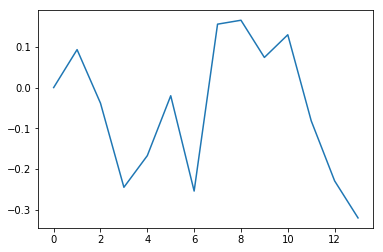

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cx_tmp)
plt.show()

위 그림처럼 for loop을 순회함에 따라 Cell State의 값이 점차 변화하는 것을 볼 수 있다.

모델을 통과한 결과물은 어떻게 생겼을까? 배치의 첫번째 데이터의 출력을 살펴보자.

In [56]:
output[0, :]

tensor([ 0.0685, -0.0379, -0.0485, -0.0881,  0.0097,  0.0413, -0.0556,
         0.1295,  0.0924, -0.0432,  0.0931, -0.0409, -0.0516, -0.0571,
        -0.0652, -0.0473,  0.2176,  0.0008, -0.0209, -0.0449, -0.0383,
         0.0927,  0.1074, -0.0555,  0.0876,  0.1509, -0.0148,  0.0381,
         0.0896,  0.0285,  0.0815, -0.0514, -0.0790, -0.0936,  0.1006])

Classifier 모듈에서 본 것처럼 확률이 아닌 logit의 형태로 출력되었다.  

보기 좋은 확률의 형태로 변형하지 않은 것은 사람 눈으로 확인해야 할 Inference 단계가 아니라면 필요가 없기 때문이다.
logit값을 에러 함수인 <a href="https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss">`nn.CrossEntropyLoss`</a>에 그대로 입력해도 학습이 잘 진행된다.

In [57]:
F.softmax(output, dim=1)[0, :]

tensor(1.00000e-02 *
       [ 3.0073,  2.7038,  2.6753,  2.5714,  2.8355,  2.9266,  2.6564,
         3.1965,  3.0801,  2.6894,  3.0821,  2.6957,  2.6669,  2.6524,
         2.6309,  2.6784,  3.4908,  2.8104,  2.7501,  2.6848,  2.7028,
         3.0809,  3.1266,  2.6567,  3.0653,  3.2657,  2.7671,  2.9174,
         3.0715,  2.8893,  3.0467,  2.6675,  2.5949,  2.5573,  3.1055])

PyTorch에서 Cross Entropy Loss를 사용할때는 모델에서 softmax를 씌우지 않고 원본 출력 결과를 그대로 입력한다. 이때 정답 label 역시 확률값이 아닌 label에 해당하는 long type의 인덱스를 넣는다. 즉, 데이터로더에서 가져오는 babyname을 target으로 만든 것을 그대로 사용하면 된다.

In [58]:
def loss_fn(outputs, labels):
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(outputs, labels)

    return loss

for loop을 통해 마지막 입력 글자까지 처리했으므로 이에 대응되는 정답은 맨 마지막 글자가 된다. 그러나 실제 학습시에는 매 글자마다 해당 정답과의 current_loss를 구한 후 이를 모두 합산해 전체 loss를 구하는 방식으로 오차를 계산한다.

In [59]:
sample_target[:, -1]

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         3,  1])

In [60]:
current_loss = loss_fn(output, sample_target[:, -1])
print(current_loss)

tensor(3.5986)


## Training

이제는 데이터셋을 사용해 모델을 학습시킬 차례다. 학습을 도와줄 몇가지 헬퍼 function을 아래와 같이 만들었다.
- MetricCalculator: 학습/검증 데이터에 대한 정확도를 기록한다.
- save_checkpoint: 모델의 파라미터를 파일로 저장한다.
- load_checkpoint: 저장한 모델 파라미터를 불러와 모델에 씌운다.
- save_dict_to_json: 모델의 학습 경과를 json 파일로 저장한다.

In [61]:
import os
import logging
from sklearn.metrics import accuracy_score

class MetricCalculator():
    """
    loss와 accuracy를 기록하기 위한 도구입니다.
    """
    def __init__(self):
        self.accuracy = 0
        self.loss_accumulated = 0
        self.average_loss = 0
        self.updated_cnt = 0

        self.predicted_labels_holder = []
        self.actual_labels_holder = []

    def update(self, outputs, labels, loss):
        self.updated_cnt += 1

        predicted_labels = outputs.max(1)[1]
        self.predicted_labels_holder.append(predicted_labels)
        self.actual_labels_holder.append(labels)
        self.loss_accumulated += loss


    def calculate_metric(self):

        predicted_labels = torch.cat(self.predicted_labels_holder).cpu().numpy()
        actual_labels = torch.cat(self.actual_labels_holder).cpu().numpy()

        self.accuracy = accuracy_score(actual_labels, predicted_labels)
        self.average_loss = self.loss_accumulated / self.updated_cnt


    def reset(self):
        self.accuracy = 0
        self.loss_accumulated = 0
        self.average_loss = 0
        self.updated_cnt = 0

    def export(self):
        return {
            'loss': self.average_loss,
            'accuracy': self.accuracy,
        }
    
def save_checkpoint(state, is_best, checkpoint, epoch):
    """
    모델을 저장합니다.
    베스트 모델인 경우 카피본을 하나 더 만듭니다.
    """
    filepath = os.path.join(checkpoint, 'e{:02d}.pth.tar'.format(epoch))
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.makedirs(checkpoint)
    else:
        print("Checkpoint Directory exists!")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """
    저장된 모델 파라미터를 불러와 업데이트합니다.
    """
    if not os.path.exists(checkpoint):
        raise ("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint
  
def save_dict_to_json(d, json_path):
    """
    dictionary를 json 파일로 저장한다.
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)

### train & evaluate

RNN의 학습은 일반적인 딥러닝의 학습과 동일하게 진행된다. 전체 데이터를 학습 / 검증 데이터셋으로 나눈다.
그리고 학습 데이터를 사용해 모델의 파라미터를 업데이트하고, 모델의 일반적인 성능을 검증하는 차원에서 검증 데이터셋을 사용한다.

아래의 train과 evaluate 함수는 모두 이름을 한글자 한글자 순회하면서 다음 글자를 출력한다.
이때 train에서는 학습 데이터에 대해 모델을 적합해야 하므로, 계산한 loss를 사용해 back propagation을 수행(`loss.backward()`)하고 optimizer를 사용해 모델의 파라미터를 업데이트(`optimizer.step()`)한다.

그러나 evaluate에서는 인퍼런스의 결과로 모델을 업데이트하지 않고 평가만 하므로, optimizer를 사용하지 않는다. 두 함수의 인자를 살펴보면 차이를 확인할 수 있다.

In [62]:
def train(model, optimizer, loss_fn, data_iterator, num_steps):
    """
    training data를 사용해서 모델을 학습하는 함수.
    """
  
    metric_watcher = MetricCalculator()

    model.train()


    for ix, batch in enumerate(data_iterator):
        inputs = batch.babyname[:, :-1].to(device)
        targets = batch.babyname[:, 1:].to(device)
        sex = batch.sex.float().to(device)
        origin = batch.origin.float().to(device)

        hidden = model.init_hidden(inputs.size(0))

        loss = 0.0

        for step in range(inputs.size(1)):
            outputs, hidden = model.forward(origin, sex, inputs[:, step], hidden)
            current_loss = loss_fn(outputs, targets[:, step])

            metric_watcher.update(outputs, targets[:, step], current_loss)
            loss += current_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    metric_watcher.calculate_metric()
    metrics_string = "loss: {:05.3f}, acc: {:05.3f}".format(
        metric_watcher.average_loss,
        metric_watcher.accuracy
    )
    print("- Train metrics: " + metrics_string)


In [63]:
def evaluate(model, loss_fn, data_iterator):
    """
    validation data를 사용해서 학습한 모델의 성능을 평가하는 함수. 
    """
  
    metric_watcher = MetricCalculator()

    # set model to evaluation mode
    model.eval()

    # compute metrics over the dataset
    for ix, batch in enumerate(data_iterator):
        inputs = batch.babyname[:, :-1].to(device)
        targets = batch.babyname[:, 1:].to(device)
        sex = batch.sex.float().to(device)
        origin = batch.origin.float().to(device)

        hidden = model.init_hidden(inputs.size(0))

        loss = 0.0

        for step in range(inputs.size(1)):
            outputs, hidden = model.forward(origin, sex, inputs[:, step], hidden)
            current_loss = loss_fn(outputs, targets[:, step])

            metric_watcher.update(outputs, targets[:, step], current_loss)
            loss += current_loss

    metric_watcher.calculate_metric()

    # compute mean of all metrics in summary
    # metrics_mean = {metric: np.nanmean([x[metric] for x in summ]) for metric in summ[0]}
    # metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    metric_watcher.calculate_metric()
    metrics_string = "loss: {:05.3f}, acc: {:05.3f}".format(
        metric_watcher.average_loss,
        metric_watcher.accuracy
    )
    print("- Eval metrics: " + metrics_string)

    return metric_watcher.export()


위에서 정의한 train과 evaluate 함수는 1 epoch을 기준으로 실행한다. epoch은 전체 데이터셋을 1회 순회하는 단위이다. 일반적으로 딥러닝에서는 전체 데이터셋을 여러번 순회하는 형태로 학습을 진행한다.

아래 train_and_evaluate 함수는 train과 evaluate를 지정한 epoch 횟수(num_epochs)만큼 수행한다. 매 epoch마다 train, validation 데이터셋에 대한 loss와 accuracy 체크를 통해 정상적으로 학습이 이루어지는지 확인할 수 있으며, 검증 정확도가 개선될때마다 베스트 모델을 저장하게끔 설정해두었다.

In [64]:
def train_and_evaluate(model, train_data_iter, val_data_iter, optimizer, loss_fn, model_dir, num_epochs, restore_file=None):
  
    """
    num_epochs만큼 학습과 검증을 하는 함수.
    """

    # if restore_file is given, load the checkpoint
    if restore_file is not None:
        restore_path = os.path.join(args.model_dir, args.restore_file + '.pth.tar')
        print("Restoring parameters from {}".format(restore_path))
        load_checkpoint(restore_path, model, optimizer)


    best_val_acc = 0.0

    for epoch in range(num_epochs):

        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        # compute number of batches in one epoch
        num_steps = len(train_data_iter.dataset.examples) // batch_size + 1
        train(model, optimizer, loss_fn, train_data_iter, num_steps)

        val_metrics = evaluate(model, loss_fn, train_data_iter)
        val_acc = val_metrics['accuracy']
        is_best = val_acc > best_val_acc

        # Save weights
        save_checkpoint({'epoch': epoch+1,
                               'state_dict': model.state_dict(),
                               'optim_dict': optimizer.state_dict()},
                              is_best=is_best,
                              checkpoint=model_dir,
                              epoch=epoch+1)

        if is_best:
            print("-- Found new best accuracy")
            best_val_acc = val_acc

            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            save_dict_to_json(val_metrics, best_json_path)




### Putting everything together

learning_rate, weight_decay 등 학습에 사용할 하이퍼파라미터를 설정한다.  
하이퍼 파라미터를 인자로 사용해 data_loader, model, optimizer, loss_fn을 정의한다.  
그리고 train_and_evaluate 함수를 사용해 학습을 실행한다.

In [65]:
import torch.optim as optim
import shutil
import json

In [66]:
# hyper parameters
learning_rate = 1e-3
weight_decay = 1e-3
model_dir = "saved"
num_epochs = 3

train_iter = data_loader.train_iter
val_iter = data_loader.val_iter

# model
model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=51,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)

# load optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# define loss function
loss_fn = loss_fn

# Train the model
print("-- start training for {} epoch(s)".format(num_epochs))
train_and_evaluate(model, train_iter, val_iter, optimizer, loss_fn, model_dir, num_epochs)

-- start training for 3 epoch(s)
Epoch 1/3
- Train metrics: loss: 1.612, acc: 0.503
- Eval metrics: loss: 1.483, acc: 0.536
Checkpoint Directory exists!
-- Found new best accuracy
Epoch 2/3
- Train metrics: loss: 1.485, acc: 0.536
- Eval metrics: loss: 1.421, acc: 0.551
Checkpoint Directory exists!
-- Found new best accuracy
Epoch 3/3
- Train metrics: loss: 1.436, acc: 0.550
- Eval metrics: loss: 1.371, acc: 0.567
Checkpoint Directory exists!
-- Found new best accuracy


### Training Result

학습 데이터에 대한 정확도가 50%에서 55%까지 개선되었다. learning_rate 등의 학습 파라미터가 나쁘지 않게 설정되었음을 알 수 있다. 10 epoch 이상 학습을 수행하면 정확도가 약 60%에 이른다. 하지만 이 이상으로 올라가기는 어려운데 이는 하이퍼파라미터의 문제라기 보다는 이름의 다음 글자를 예측하는 문제 자체의 한계로 보인다. 예를 들어 영국 여성의 이름이 "Lucy"와 "Lucie"가 있다고 하자. "L", "u", "c"까지 처리했을 때 다음 정답은 "y"와 "i" 둘 다 가능하다. 그러나 정확도 측정에는 반드시 하나의 정답만 사용하므로 100% 맞추는 것 자체가 불가능해진다. 

학습과 검증 데이터셋의 정확도는 서로 큰 차이가 나지 않으며 둘 다 점진적으로 개선되는 경향을 보인다. 이를 통해 학습 데이터에 모델이 지나치게 적합되는 오버피팅이 발생하지 않고 정상적으로 학습이 잘 이루어졌음을 알 수 있다.

### Load Best Model

가장 좋은 성능을 기록한 모델 파라미터는 아래와 같이 기존 모델에 덮어씌울 수 있다.

In [67]:
best_model_path = "saved/best.pth.tar"

checkpoint = load_checkpoint(best_model_path, model)

## Name Generation

완성된 모델을 사용해 이름을 만들어 볼 차례다. 
러시아인 남성으로 "K"로 시작하는 이름을 짓어보자.

모델이 해야할 일은, "K" 다음에 올 글자를 예측하고,  
예측한 문자를 다시 입력받아 그 다음 문자를 예측한다.  
이 과정을 eos가 출력될 때까지 반복하면 이름이 완성된다.

앞서 모델 구조에서 살펴보았듯, 모델은 35개 문자가 가진 각각의 확률값을 logit으로 반환한다.  
그 35개 값 중에서 가장 큰 값을 가진 문자가 모델이 생각하는 가장 유력한 다음 글자라 할 수 있다.

따라서 매번 가장 logit이 큰 문자를 선택하고 이를 다시 입력으로 넣는 방식으로 이름을 생성할 수 있다.

아래와 같이 처음 글자 시퀀스를 prime으로 정의하여 다음 문자의 확률을 리턴하는 `sample` 함수를 정의한다.

In [68]:
def sample(data_loader, net, prime, sex, origin):
    """
    문화권, 성별과 시작 글자묶음을 입력받아
    다음 글자들의 확률을 리턴한다.
    """
    origin_tensor = data_loader.ORIGIN.process([origin]).float().to(device)
    sex_tensor = data_loader.SEX.process([sex]).float().to(device)

    prime = prime.lower()
    prime_tensor = data_loader.BABYNAME.process([prime])[:, :-1].to(device)
    bsz, prime_tensor_length = prime_tensor.size()

    # 인풋을 모델에 넣어 출력합니다.
    net.eval()
    with torch.no_grad():
        # batch_size = 1
        hidden = net.init_hidden(1)

        for step in range(prime_tensor_length):
            with torch.no_grad():
                outputs, hidden = net(origin_tensor, sex_tensor, prime_tensor[:, step], hidden)
            probabilities = F.softmax(outputs, 1)

    return probabilities.squeeze()

`sample` 함수는 "K"와 "boy", "Russian"을 입력받아 35개 문자의 확률을 리턴한다. LTSM의 hx, cx는 리턴하지 않도록 함수를 설계했다.

In [69]:
probabilities = sample(data_loader, model, "K", "boy", "Russian")

확률이 가장 큰 값은 5번째 인덱스다.

In [70]:
max_idx = probabilities.argmax().item()
print(max_idx)

4


이를 torchtext에서 만든 사전을 통해 문자로 바꾸면..


In [71]:
data_loader.BABYNAME.vocab.itos[max_idx]

'a'

다음 글자가 나왔으므로 이를 원래 prime인 "K"에 더해 "Ka"를 만들고 다시 `sample`함수를 실행한다.  
이 과정을 eos가 나올 때까지 반복한다.

In [72]:
prime = "Ka"
sex = "boy"
origin = "Russian"

chr_list = list(prime)
print("initial_prime: ", chr_list)

while chr_list[-1] != "<eos>":
    current_prime = "".join(chr_list)
    probabilities = sample(data_loader, model, current_prime, sex, origin)
    max_idx = probabilities.argmax().item()
    next_chr = data_loader.BABYNAME.vocab.itos[max_idx]
    chr_list.append(next_chr)

generated_name = "".join(chr_list[:-1])
print("generated_name: ", generated_name)

initial_prime:  ['K', 'a']
generated_name:  Kati


`Karis`라는 이름이 생성되었다. 
하지만 같은 함수를 몇번을 다시 돌려봐도 `Ke`로 시작하는 다른 이름을 얻을 수 없다. 

그 이유는 명확하다. `Ke` 다음에 오는 문자를 확률이 가장 높은 글자를 선택했기 때문이다.  
그리고 모델이 바뀌지 않는 한 그 확률값은 모델을 몇번을 다시 돌려도 같은 값이 출력된다.  

즉, 이와 같은 방식으로 이름을 생성하면 다양한 이름을 생성하기 어렵다.  
보다 더 다양한 이름을 만들기 위해 Beam-Search 같은 방식을 사용해 볼 수 있다.

## Name Generation with Beam-Search

Beam-Search는 매 스텝마다 beam 갯수(K)만큼 후보를 유지하면서 서치를 하는 방식이다.

Beam-search는 다음과 같은 방식으로 동작한다.
- 바스켓(OrderedDict)를 생성하고, 첫 엔트리로 prime과 그 확률 0.0을 입력한다.
- While True:
  - 바스켓의 키를 그 확률을 기준으로 정렬한 후 K개만 남긴다.
  - 모든 키에 eos가 있으면 해당 키 서치를 종료한다.
  - eos가 없는 바스켓의 키를 순회한다.
      - 문화권, 성별, 키를 모델에 넣어 35개 확률을 출력한다.
      - 각 문자/확률을 순회한다.
        - 기존 키와 새로운 문자를 조합해 새로운 키를 만든다.
        - 새 확률에 log를 취한 후 기존 키의 확률에 더한다.
        - 새 키의 길이를 사용해 새 키의 확률을 노멀라이즈한다.
        - 노멀라이즈한 확률을 새로운 키의 확률에 할당해 바스켓에 저장한다.
  - 바스켓에서 기존 키를 삭제한다.
  - 새로운 키를 바스켓에 채워넣는다.

Beam-Search는 모든 후보가 eos로 마무리될때까지 가장 확률이 높은 K개의 후보군을 유지한다.  
K=1이면 위에서 본 greedy한 생성방식과 일치하게 된다. K를 높임에 따라 더 많은 후보를 만들어낼 수 있지만,
그 반대급부로 계산량이 늘어나게 된다.  

#### 후보 확률 계산하기

확률이 높음은 어떻게 계산해야 할까? 여기서는 그 다음 글자의 확률을 보는 것이 아니라, 갱신된 prime의 생성 확률을 봐야한다.

"K"를 prime으로 넣어 "Karis"를 얻었다고 하자. Karis가 생성될 확률은 (문화권과 성별 변수를 잠시 제외하면)
$p(Karis) = p(K) * p(a|K) * p(r|Ka) * p(i|Kar) * p(s|Kari) * p(<eos>|Karis)$
라 할 수 있다. 

그래서 매 스텝마다 새로 나오는 확률값을 기존 확률값에 계속 재귀적으로 곱해주면 된다.  
그런데 문제는, 확률값은 0에서 1 사이의 숫자인데다 작은 경우가 많아서, 이를 계속 곱해주다보면 소숫점이 굉장히 길어지는 문제가 있다.  
컴퓨터가 계산하기 곤란한 정도로 소숫점이 많아지면 후보간의 비교가 어려워진다.  
따라서 이를 쉽게 하기 위해 전체에 log를 씌우면, 앞뒤 확률간의 곱이 앞뒤 확률의 log의 합으로 표현할 수 있게 된다.

$\log(p(Karis)) = \log(p(K)) + \log(p(a|K)) + \log(p(r|Ka)) + \log(p(i|Kar)) + \log(p(s|Kari)) + \log(p(<eos>|Karis))$



#### 길이에 따른 확률 보정

Beam-Search 코드를 보면 log 확률의 합을 구한 다음 prime의 길이로 정규화를 한다.  
0에서 1사이의 확률에 log를 취하면 -inf에서부터 0 사이의 값이 된다. 이를 계속 더해주면 그 총합이 계속 낮아지게 된다.  
즉, 생성하는 길이가 길어지면 길어질수록 그 후보의 확률이 낮아진다는 의미다.  
이를 보정하지 않으면 Beam-Search는 짧은 이름 후보를 선호하는 경향을 보이게 된다.  
하지만 이는 도메인에 따라 다른 것이므로, 하이퍼 파라미터 `alpha`를 넣어 얼마나 보정할 것인지를 보통 결정하게 한다. 

아래 구현된 Beam-Search 코드를 통해 이름을 생성해보자!

In [73]:
from collections import OrderedDict
import numpy as np

def clean_beam_basket(basket, beam_width):
    """
    가장 확률이 높은 beam_width개만 남기고 바스켓을 비운다.
    """
    _tmp_basket = basket.copy()
    to_remove = sorted(_tmp_basket.items(), key=lambda x: x[1], reverse=True)[beam_width:]
    for item in to_remove:
        _tmp_basket.pop(item[0])

    return _tmp_basket

def beam_search(data_loader, net, beam_width, alpha, prime, sex, origin):
    # print("Sampling a {} {} name beginning with {}..".format(origin, sex, prime))

    beam_basket = OrderedDict()
    beam_basket[prime] = 0.0

    counter = 0
    
    while True:
        counter += 1

        # 바스켓을 청소합니다.
        beam_basket = clean_beam_basket(beam_basket, beam_width)

        # 만약 바스켓에 모든 아이템이 <eos>가 있으면 루프를 멈춘다.
        eos_cnt = 0
        for k in beam_basket.keys():
            if "<eos>" in k:
                eos_cnt += 1
        if eos_cnt == beam_width:
            # print("all items have <eos>")
            break

        # 모든 key를 돌면서
        ## <eos>가 없는 경우 inference한다.
        new_entries = {}
        to_remove = []
        for k in beam_basket.keys():
            if "<eos>" not in k:
                probabilities = sample(data_loader, net, prime=k, sex=sex, origin=origin)
                for ix, prob in enumerate(probabilities):
                    new_k = k + data_loader.BABYNAME.vocab.itos[ix]
                    added_probability = beam_basket[k] + torch.log(prob).item()
                    len_k = len(k.replace("<eos>", ""))
                    normalized_probability = (1 / (len(k) ** alpha)) * added_probability
                    new_entries[new_k] = normalized_probability
                to_remove.append(k)
    
        # 그리고 기존 key를 beam_basket에서 지운다.
        for k in to_remove:
            beam_basket.pop(k)

        # 새로운 키를 바스켓에 채워넣는다.
        for k, v in new_entries.items():
            beam_basket[k] = v

    final_list = []
    for k, v in beam_basket.items():
        refined_k = k.replace("<eos>", "").capitalize()
        final_list.append(refined_k)
        final_prob = np.exp(v)

    return final_list

def generate_names(data_loader, model_dir, prime, sex, origin, beam_width=3, alpha=0.7):
    """
    이름을 생성하는 주요 함수다.
    """
    
    model = Net(vocab_size=35, embedding_dim=100,
                 nb_sex=2, nb_origin=51,
                 lstm_nb_layers=1, lstm_hidden_dim=200,
                fc_out=300, dropout_p=0.5, 
           ).to(device)
    
    weight_path = os.path.join(model_dir, "best.pth.tar")
    checkpoint = load_checkpoint(weight_path, model)

    final_list = beam_search(data_loader, model, prime=prime, sex=sex, origin=origin, beam_width=beam_width, alpha=alpha)
   
    return final_list


In [74]:
generate_names(data_loader, "saved", "Mi", "girl", "British")

['Millee', 'Millie', 'Mirlee']

In [75]:
generate_names(data_loader, "saved", "Mi", "girl", "Japanese")

['Miko', 'Mikola', 'Mikoli']

In [76]:
generate_names(data_loader, "saved", "Mi", "girl", "Chinese")

['Milla', 'Millena', 'Millene']

## Outro

이번 포스팅에서는 Recurrent Neural Network의 개념에 대해 알아보았다.  
RNN을 사용해서 문화권, 성별, 글자가 주어졌을 때 적절한 이름이 되도록 다음 글자를 예측하는 모델을 학습하고,  
Beam-Search 기법으로 다양한 variation을 가진 이름을 생성해보았다.  

이번에 만들어본 이름을 짓는 딥러닝 모델은 적은 데이터와 적은 학습 시간에도 불구하고 꽤 그럴듯한 이름을 만들어낸다.  
가짓수가 충분한 영국, 스페인, 일본쪽 이름은 문화권에 따른 특징도 잘 드러난다.  

크롤링한 데이터에 한국 이름은 없어 아쉽다.  
한글 이름 데이터셋을 얻어 이름 짓는 모델을 학습시킨다면 먼 미래에 자식들에게 해줄 흥미로운 얘깃거리가 하나 더 생기지 않을까-

## Reference

1) http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
2) http://colah.github.io/posts/2015-08-Understanding-LSTMs/  
3) https://medium.com/@andre.holzner/lstm-cells-in-pytorch-fab924a78b1c  